# Extraction of studies via Databases & Registers

In [1]:
# Standard Packages 
import pandas as pd
import unicodedata
import time
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
from datetime import datetime
from typing import Dict, List, Optional, Iterable, Tuple
import unicodedata

# API Call Packages
import urllib
import requests
import json

## Load API Keys

In [2]:
load_dotenv()

# load api keys from .env
api_key_WoS = os.getenv('WEB_OF_SCIENCE_API_KEY')
api_key_SS = os.getenv('SEMANTIC_SCHOLAR_API_KEY')

# Check if API keys are loaded
print(f"Web of Science API Key: {api_key_WoS[:3]}...")  # Print first 4 characters
print(f"Semantic Scholar API Key: {api_key_SS[:3]}...")  # Print first 4 characters

Web of Science API Key: 7c0...
Semantic Scholar API Key: eU3...


## Web of Science API Call

**Search and field tags for Web of Science documents**
- `sort_field`: Order by field(s). 
    - Field name and order by clause separated by '+', use A for ASC and D for DESC, 
    - Example: `PY+D`. Multiple values are separated by comma. 
    - Supported fields:  * **LD** - Load Date * **PY** - Publication Year * **RS** - Relevance * **TC** - Times Cited  (optional)
- `...time_span`: Beginning and end dates must be specified in the yyyy-mm-dd format separated by '+' or ' ', e.g. 2023-01-01+2023-12-31. This parameter is not compatible with the all databases search, i.e. db=WOK is not compatible with this parameter. (optional)


In [3]:
# Import WoS API client
import clarivate.wos_starter.client
from clarivate.wos_starter.client.rest import ApiException
from pprint import pprint

In [4]:
# Set up Web of Science API client
BASE_WoS = "https://api.clarivate.com/apis/wos-starter/v1"
configuration = clarivate.wos_starter.client.Configuration(host = BASE_WoS)
configuration.api_key['ClarivateApiKeyAuth'] = api_key_WoS

In [5]:
# Define Functions
# -------------- Function to run API query --------------
def run_wos_api(
        q,                          # Search query in WOS search syntax
        db='WOS',                       # Choice of Database
        limit=50,                       # Set limit of records on page (1-50) (default to 10)
        page=1,                         # Set the result page 
        sort_field='RS+D',              # Order by Field(s), option: LD, PY, RS, TC
        modified_time_span=None,        # Date range in which results were most recently modified.
        tc_modified_time_span=None,     # Date range in which times cited counts were modified.
        detail=None,                    # Set to returns full data by default, alternative: detail=short
        configuration=configuration ):

    with clarivate.wos_starter.client.ApiClient(configuration) as api_client:
        api_instance = clarivate.wos_starter.client.DocumentsApi(api_client)
        try:
            api_response = api_instance.documents_get(
                q,
                db=db,
                limit=limit,
                page=page,
                sort_field=sort_field,
                modified_time_span=modified_time_span,
                tc_modified_time_span=tc_modified_time_span,
                detail=detail
            )
            return api_response
        
        except ApiException as e:
            print(f"Exception when calling DocumentsApi->documents_get: {e}")
            return None
        
# -------------- Function to Fetch --------------
# Funciton: Fetch X number of pages
def wos_fetch_pages(q: str, limit: int = 50) -> pd.DataFrame:
    all_hits = []

    for p in range(1, 11):  # pages 1-10
        resp = run_wos_api(q, page=p, limit=limit)
        if resp is None:
            print(f"[WARN] No response for page {p}")
            continue
        hits = getattr(resp, "hits", []) or []
        all_hits.extend(h.to_dict() for h in hits)

    if not all_hits:
        return pd.DataFrame()

    df = pd.DataFrame(all_hits)
    if "uid" in df.columns:
        df = df.drop_duplicates(subset=["uid"]).reset_index(drop=True)
    return df

# Funciton: Fetch ALL pages
def wos_fetch_all_pages(q: str, limit: int = 50) -> pd.DataFrame:
    # Step 1: Fetch the first page to get the total number of records
    resp = run_wos_api(q, page=1, limit=limit)
    if resp is None:
        print(f"[WARN] No response for the first page of query: {q}")
        return pd.DataFrame()

    total_records = getattr(resp.metadata, "total", 0)  # Get the total number of records
    if total_records == 0:
        print(f"[WARN] No records found for query: {q}")
        return pd.DataFrame()

    # Step 2: Calculate the number of pages required
    total_pages = (total_records + limit - 1) // limit  # equivalent to math.ceil(total_records / limit)

    # Step 3: Loop through all pages and collect the records
    all_hits = []
    for page in range(1, total_pages + 1):
        resp = run_wos_api(q, page=page, limit=limit)
        if resp is None:
            print(f"[WARN] No response for page {page} of query: {q}")
            continue

        hits = getattr(resp, "hits", []) or []
        all_hits.extend(h.to_dict() for h in hits)

    if not all_hits:
        return pd.DataFrame()

    # Step 4: Convert the results to a DataFrame
    df = pd.DataFrame(all_hits)
    
    # Deduplicate based on 'uid' (unique identifier)
    if "uid" in df.columns:
        df = df.drop_duplicates(subset=["uid"]).reset_index(drop=True)

    return df

# Function: Get total record counts for each query
def wos_query_totals(wos_queries: dict) -> pd.DataFrame:
    results = []
    for name, q in wos_queries.items():
        resp = run_wos_api(q, page=1, limit=1)
        print(f"Processing query: {name}")
        
        if resp is None:
            results.append({"QueryName": name, "TotalRecords": None})
            continue

        total = getattr(resp.metadata, "total", None)
        results.append({"QueryName": name, "TotalRecords": total})

    return pd.DataFrame(results).sort_values("TotalRecords", ascending=False).reset_index(drop=True)

In [17]:
# Define search terms

# 1. LLM Block
LLM_Block = 'TS=("large language model*" OR "foundation model*" OR LLM OR LLMs OR GPT OR LLaMA* OR Mistral OR Mixtral OR Claude* OR Gemini OR PaLM OR Qwen OR DeepSeek OR "Falcon 180B" OR "Phi-3")'

# 2. Survey Block
Survey_Block = 'TS=(survey* OR "survey data" OR "survey response*" OR questionnaire* OR question* OR "opinion poll*" OR "public opinion*" OR attitude* OR value* OR norm* OR moral* OR "feeling thermometer*" OR "open-ended" OR "open ended" OR nonresponse OR "non-response" OR respondent* OR participant* OR interview* OR "self-report*" OR "data collection")'

# 3. Simulation Block (merged A+B)
Simulation_BlockA = 'TS=((simulat* OR emulat* OR predict* OR imput* OR "missing data" OR nonresponse OR "non-response" OR "item nonresponse" OR "unit nonresponse" OR "synthetic respondent*" OR "synthetic participant*" OR "artificial respondent*" OR "artificial participant*" OR "virtual respondent*" OR "virtual participant*" OR persona* OR "role play*") NEAR/5 (survey* OR questionnaire* OR respondent* OR response* OR interview* OR "self-report*" OR "data collection" OR opinion* OR poll*))'

# 3. 2nd version of  Simulation Block (more comprehensive)
Simulation_BlockB = 'TS=( ( simulat* OR emulat* OR predict* OR imput* OR "synthetic data" OR "missing data" OR nonresponse OR "non-response" OR "item nonresponse" OR "synthetic respondent*" OR "synthetic participant*" OR "artificial respondent*" OR "artificial participant*" OR "virtual respondent*" OR "virtual participant*" OR persona* OR "role play*" OR "as a respondent" OR "LLM as respondent" OR "model as respondent" OR proxy OR surrogate OR "stand-in" OR "stand in" OR replac* OR substitut* OR represent* OR fidelit* OR faithful* OR doppelg* OR ("Synthetic Voice*" NEAR/5 (persona* OR respondent* OR survey* OR "public opinion*" OR opinion*)) OR ("representing people" NEAR/3 (survey* OR respondent* OR persona* OR opinion*)) OR ("LLM-generated persona*" OR "LLM generated persona*") ) NEAR/5 (survey* OR questionnaire* OR respondent* OR response* OR interview* OR "self-report*" OR "data collection" OR opinion* OR poll* OR attitude* OR value* OR norm* OR "public opinion*") )'

# 3. 3rd version of  Simulation Block (fixed phrases)
Simulation_BlockC = 'TS=("survey simulation" OR "simulated participant*" OR "simulated respondent*" OR "synthetic data" OR "synthetic survey data" OR "synthetic respondent*" OR "synthetic participant*" OR "artificial respondent*" OR "artificial participant*" OR "virtual respondent*" OR "virtual participant*" OR "LLM as respondent" OR "model as respondent" OR "as a respondent" OR "role play*" OR persona*)'

# 4. Model Training Block (optional)
Methods_Block = 'TS=( prompt* OR "few-shot" OR "few-shot learning" OR "zero-shot" OR "zero-shot learning" OR "in-context learning" OR ICL OR "chain of thought" OR "self-consistency" OR "system message" OR persona OR personas OR "role prompt*" OR "instruction-tun*" OR "instruction prompt*" OR "fine-tun*" OR ("reinforcement learning with human feedback" OR RLHF) OR ("reinforcement learning with AI feedback" OR RLAIF) OR "temperature parameter" OR "temperature setting" OR "nucleus sampling" OR "top-p sampling" OR "active learning" OR "transfer learning" OR "meta learning" OR "meta-learning" OR "representation learning" OR "continual learning" OR "lifelong learning" )'

# Create combinations of search blocks with Exclusion Block
LLM_and_Survey = f'{LLM_Block} AND {Survey_Block}'
LLM_and_Survey_and_Methods = f'{LLM_Block} AND {Survey_Block} AND {Methods_Block}'
LLM_and_SimulationA = f'{LLM_Block} AND {Simulation_BlockA}'
LLM_and_SimulationB = f'{LLM_Block} AND {Simulation_BlockB}'
LLM_and_SimulationC = f'{LLM_Block} AND {Simulation_BlockC}'
LLM_and_Methods = f'{LLM_Block} AND {Methods_Block}'
LLM_and_Survey_and_SimulationA = f'{LLM_Block} AND {Survey_Block} AND {Simulation_BlockA}'
LLM_and_Survey_and_SimulationB = f'{LLM_Block} AND {Survey_Block} AND {Simulation_BlockB}'
LLM_and_Survey_and_SimulationC = f'{LLM_Block} AND {Survey_Block} AND {Simulation_BlockC}'
LLM_and_SimulationA_and_Methods = f'{LLM_Block} AND {Simulation_BlockA} AND {Methods_Block}'
LLM_and_SimulationB_and_Methods = f'{LLM_Block} AND {Simulation_BlockB} AND {Methods_Block}'
LLM_and_SimulationC_and_Methods = f'{LLM_Block} AND {Simulation_BlockC} AND {Methods_Block}'
LLMSurvey_or_LLMSimulationA = f'({LLM_and_Survey}) OR ({LLM_and_SimulationA})'
LLMSurvey_or_LLMSimulationB = f'({LLM_and_Survey}) OR ({LLM_and_SimulationB})'
LLMSurvey_or_LLMSimulationC = f'({LLM_and_Survey}) OR ({LLM_and_SimulationC})'
Survey_and_SimulationA = f'{Survey_Block} AND {Simulation_BlockA}'
Survey_and_SimulationB = f'{Survey_Block} AND {Simulation_BlockB}'
Survey_and_SimulationC = f'{Survey_Block} AND {Simulation_BlockC}'

In [9]:
# DEFINE Set of Queries
wos_queries = {
    "LLM": LLM_Block,
    "Survey": Survey_Block,
    "SimulationB": Simulation_BlockB,
    "LLM and Survey": LLM_and_Survey,
    "LLM and Survey and Methods": LLM_and_Survey_and_Methods,
    "LLM and SimulationA": LLM_and_SimulationA,
    "LLM and SimulationB": LLM_and_SimulationB,
    "LLM and SimulationC": LLM_and_SimulationC,
    "LLM and Methods": LLM_and_Methods,
    "LLM and Survey and SimulationA": LLM_and_Survey_and_SimulationA,
    "LLM and Survey and SimulationB": LLM_and_Survey_and_SimulationB,
    "LLM and Survey and SimulationC": LLM_and_Survey_and_SimulationC,
    "LLM and SimulationA and Methods": LLM_and_SimulationA_and_Methods,
    "LLM and SimulationB and Methods": LLM_and_SimulationB_and_Methods,
    "LLM and SimulationC and Methods": LLM_and_SimulationC_and_Methods,
    "LLMSurvey or LLMSimulationA": LLMSurvey_or_LLMSimulationA,
    "LLMSurvey or LLMSimulationB": LLMSurvey_or_LLMSimulationB,
    "LLMSurvey or LLMSimulationC": LLMSurvey_or_LLMSimulationC,
    "Survey and SimulationA": Survey_and_SimulationA,
    "Survey and SimulationB": Survey_and_SimulationB,
    "Survey and SimulationC": Survey_and_SimulationC
}

wos_queries_subset = {
    #"LLM_and_SimulationA": LLM_and_SimulationA,
    #"LLM_and_SimulationB": LLM_and_SimulationB,
    #"LLM_and_Survey_and_SimulationA": LLM_and_Survey_and_SimulationA,
    "LLM_and_Survey_and_SimulationB": LLM_and_Survey_and_SimulationB,
    #"LLM_and_SimulationA_and_Methods": LLM_and_SimulationA_and_Methods,
    #"LLM_and_SimulationB_and_Methods": LLM_and_SimulationB_and_Methods,
    #"LLMSurvey or LLMSimulationA": LLMSurvey_or_LLMSimulationA,
    #"LLMSurvey or LLMSimulationB": LLMSurvey_or_LLMSimulationB,   
}

In [ ]:
# RUN: Get Max Total records
df_WoS_totals = wos_query_totals(wos_queries_subset)
df_WoS_totals

Processing query: LLM_and_SimulationA
Processing query: LLM_and_SimulationB
Processing query: LLM_and_Survey_and_SimulationA
Processing query: LLM_and_Survey_and_SimulationB
Processing query: LLM_and_SimulationA_and_Methods
Processing query: LLM_and_SimulationB_and_Methods


,QueryName,TotalRecords
0,LLM_and_SimulationB,2185
1,LLM_and_Survey_and_SimulationB,1680
2,LLM_and_SimulationA,829
3,LLM_and_Survey_and_SimulationA,447
4,LLM_and_SimulationB_and_Methods,331
5,LLM_and_SimulationA_and_Methods,171


In [ ]:
# RUN Fetch for ALL queries
dfs_WoS = {}
for name, query in wos_queries.items():
    print(f"\nFetching WoS results for: {name}")
    df = wos_fetch_all_pages(query, limit=50)
    print(f"{name}: {len(df)} rows")
    dfs_WoS[name] = df

In [10]:
# RUN Fetch for SUBSET of queries
dfs_WoS_subset = {}
for query_name, query in wos_queries_subset.items():
    print(f"Fetching records for query: {query_name}")
    df_results = wos_fetch_all_pages(query)
    dfs_WoS_subset[query_name] = df_results

Fetching records for query: LLM_and_Survey_and_SimulationB


In [14]:
# Define Functions to clean and normalize WoS DataFrames
def authors_from_names(names_obj):
    if isinstance(names_obj, dict):
        people = names_obj.get("authors") or []
        out = []
        for a in people:
            if isinstance(a, dict):
                dn = a.get("displayName") or a.get("wosStandard") or a.get("full_name") or ""
                if dn:
                    out.append(dn)
        return "; ".join(out)
    return ""

def keywords_from_obj(keywords_obj):
    if isinstance(keywords_obj, dict):
        ak = keywords_obj.get("authorKeywords")
        if isinstance(ak, list):
            return "; ".join([k for k in ak if isinstance(k, str)])
        if isinstance(ak, str):
            return ak
    return ""

def doi_from_identifiers(ident_obj):
    if isinstance(ident_obj, dict):
        doi = ident_obj.get("doi")
        if doi:
            return doi
        dois = ident_obj.get("dois")
        if isinstance(dois, list) and len(dois) > 0:
            return dois[0]
    return None

def issn_from_identifiers(ident_obj):
    if isinstance(ident_obj, dict):
        val = ident_obj.get("issn")
        issn = val[0] if isinstance(val, list) and val else val
        return issn
    return None

def isbn_from_identifiers(ident_obj):
    if isinstance(ident_obj, dict):
        val = ident_obj.get("isbn")
        isbn = val[0] if isinstance(val, list) and val else val
        return isbn
    return None

def year_from_source(src_obj):
    if isinstance(src_obj, dict):
        return src_obj.get("publishYear") or src_obj.get("publishedYear")
    return None

def first_source_type(st_list):
    if isinstance(st_list, list) and st_list:
        return st_list[0]
    return None

def clean_wos_df(df_raw: pd.DataFrame) -> pd.DataFrame:
    if df_raw is None or df_raw.empty:
        return pd.DataFrame(columns=["title", "authors", "doi", "year", "keywords", "sourceType"])

    df = df_raw.copy()

    # Compute desired fields
    df["authors"] = df["names"].apply(authors_from_names) if "names" in df.columns else ""
    df["doi"] = df["identifiers"].apply(doi_from_identifiers) if "identifiers" in df.columns else None
    df["issn"] = df["identifiers"].apply(issn_from_identifiers) if "identifiers" in df.columns else None
    df["isbn"] = df["identifiers"].apply(isbn_from_identifiers) if "identifiers" in df.columns else None
    df["year"] = df["source"].apply(year_from_source) if "source" in df.columns else None
    df["keywords"] = df["keywords"].apply(keywords_from_obj) if "keywords" in df.columns else ""
    df["sourceType"] = df["sourceTypes"].apply(first_source_type) if "sourceTypes" in df.columns else None

    # Drop intermediate/noisy columns
    to_drop = ["uid", "types", "sourceTypes", "source", "names", "links", "citations", "identifiers"]
    df = df.drop(columns=[c for c in to_drop if c in df.columns], errors="ignore")

    # Reorder columns (keep others after the key fields)
    key_cols = [c for c in ["title", "authors", "doi", "issn", "isbn",
                            "year", "keywords", "sourceType"] if c in df.columns]
    other_cols = [c for c in df.columns if c not in key_cols]
    df = df[key_cols + other_cols]

    return df

In [ ]:
# RUN Cleaning for Allsets
dfs_WoS_clean = {name: clean_wos_df(df) for name, df in dfs_WoS_clean.items()}

df_WoS_LLM_and_Survey_clean = dfs_WoS_clean["LLM and Survey"]
df_WoS_LLM_and_Survey_and_Methods_clean = dfs_WoS_clean["LLM and Survey and Methods"]
df_WoS_LLM_and_SimulationA_clean = dfs_WoS_clean["LLM and SimulationA"]
df_WoS_LLM_and_SimulationB_clean = dfs_WoS_clean["LLM and SimulationB"]
df_WoS_LLM_and_SimulationC_clean = dfs_WoS_clean["LLM and SimulationC"]
df_WoS_LLM_and_Methods_clean = dfs_WoS_clean["LLM and Methods"]
df_WoS_LLM_and_Survey_and_SimulationA_clean = dfs_WoS_clean["LLM and Survey and SimulationA"]
df_WoS_LLM_and_Survey_and_SimulationB_clean = dfs_WoS_clean["LLM and Survey and SimulationB"]
df_WoS_LLM_and_Survey_and_SimulationC_clean = dfs_WoS_clean["LLM and Survey and SimulationC"]
df_WoS_LLM_and_SimulationA_and_Methods_clean = dfs_WoS_clean["LLM and SimulationA and Methods"]
df_WoS_LLM_and_SimulationB_and_Methods_clean = dfs_WoS_clean["LLM and SimulationB and Methods"]
df_WoS_LLM_and_SimulationC_and_Methods_clean = dfs_WoS_clean["LLM and SimulationC and Methods"]
df_WoS_LLMSurvey_or_LLMSimulationA_clean = dfs_WoS_clean["LLMSurvey or LLMSimulationA"]
df_WoS_LLMSurvey_or_LLMSimulationB_clean = dfs_WoS_clean["LLMSurvey or LLMSimulationB"]
df_WoS_LLMSurvey_or_LLMSimulationC_clean = dfs_WoS_clean["LLMSurvey or LLMSimulationC"]
df_WoS_Survey_and_SimulationA_clean = dfs_WoS_clean["Survey and SimulationA"]
df_WoS_Survey_and_SimulationB_clean = dfs_WoS_clean["Survey and SimulationB"]
df_WoS_Survey_and_SimulationC_clean = dfs_WoS_clean["Survey and SimulationC"]

In [15]:
# RUN Cleaning for Subset
dfs_WoS_subset_clean = {name: clean_wos_df(df) for name, df in dfs_WoS_subset.items()}

# Bind cleaned dataframes to variables
#df_WoS_LLM_and_SimulationA = dfs_WoS_subset_clean["LLM_and_SimulationA"]
#df_WoS_LLM_and_SimulationB = dfs_WoS_subset_clean["LLM_and_SimulationB"]
#df_WoS_LLM_and_Survey_and_SimulationA = dfs_WoS_subset_clean["LLM_and_Survey_and_SimulationA"]
df_WoS_LLM_and_Survey_and_SimulationB = dfs_WoS_subset_clean["LLM_and_Survey_and_SimulationB"]
#df_WoS_LLM_and_SimulationA_and_Methods = dfs_WoS_subset_clean["LLM_and_SimulationA_and_Methods"]
#df_WoS_LLM_and_SimulationB_and_Methods = dfs_WoS_subset_clean["LLM_and_SimulationB_and_Methods"]

In [9]:
# Save cleaned dataframes to CSV files
#df_WoS_LLM_and_Survey_and_SimulationB.to_csv("results_wos/df_WoS_LLM_and_Survey_and_SimulationB.csv", index=False)
# load saved dataframes
df_WoS_LLM_and_Survey_and_SimulationB = pd.read_csv("results_wos/df_WoS_LLM_and_Survey_and_SimulationB.csv")

## Semantic Scholar API Call

In [18]:
from semanticscholar import SemanticScholar

In [ ]:
# Define Search Parameters
FIELDS_SS = ["paperId", "title", "year", "authors", "abstract", "url", 
             "citationCount", "externalIds", "publicationTypes"]
YEAR_FILTER = "2022-"
BULK_SORT = "citationCount:desc"
MAX_PAPERS_PER_GROUP = 1000

In [51]:
# Define Search Function

# -------- Helper Functions --------
def author_names(paper_authors):
    if not paper_authors:
        return ""
    names = []
    for a in paper_authors:
        # supports Author objects and dicts
        names.append(getattr(a, "name", a.get("name") if isinstance(a, dict) else None))
    return ", ".join([n for n in names if n])

def _safe_get(container, key):
    """Access dict or object attribute safely."""
    if container is None:
        return None
    if isinstance(container, dict):
        return container.get(key)
    return getattr(container, key, None)

def _fos_to_str(x):
    if not x:
        return None
    vals = []
    if isinstance(x, list):
        for it in x:
            if isinstance(it, str):
                vals.append(it)
            elif isinstance(it, dict):
                vals.append(it.get("name") or it.get("category"))
            else:
                vals.append(getattr(it, "name", None) or getattr(it, "category", None))
    if not vals:
        return None
    vals = [v for v in vals if v]
    return "; ".join(sorted(set(vals))) if vals else None

def _enrich_fos_with_batch(df: pd.DataFrame, sch: SemanticScholar) -> pd.DataFrame:
    ids = [i for i in df.get("paperId", pd.Series()).dropna().astype(str).unique().tolist() if i]
    if not ids:
        df[["fieldsOfStudy", "s2FieldsOfStudy"]] = None
        return df
    chunksize = 100  # /graph/v1/paper/batch limit
    rows = []
    for i in range(0, len(ids), chunksize):
        batch = ids[i:i+chunksize]
        papers = sch.get_papers(batch, fields=["paperId", "fieldsOfStudy", "s2FieldsOfStudy"])
        for p in papers or []:
            pid = getattr(p, "paperId", None)
            fos = getattr(p, "fieldsOfStudy", None)
            s2  = getattr(p, "s2FieldsOfStudy", None)
            rows.append({
                "paperId": pid,
                "fieldsOfStudy": _fos_to_str(fos),
                "s2FieldsOfStudy": _fos_to_str(s2),
            })
    fos_df = pd.DataFrame(rows).drop_duplicates(subset=["paperId"]) if rows else pd.DataFrame(columns=["paperId","fieldsOfStudy","s2FieldsOfStudy"])
    return df.merge(fos_df, on="paperId", how="left")

def ss_paper_row(p):
    ext = getattr(p, "externalIds", None)

    return {
        "paperId": getattr(p, "paperId", None),
        "title": getattr(p, "title", None),
        "year": getattr(p, "year", None),
        "authors": author_names(getattr(p, "authors", None)),
        "abstract": getattr(p, "abstract", None),
        "url": getattr(p, "url", None),
        "citationCount": getattr(p, "citationCount", None),
        "doi": _safe_get(ext, "DOI") or _safe_get(ext, "doi"),
        "publicationTypes": getattr(p, "publicationTypes", None),
    }

# -------- Main Fetch Function --------

# Funciton: Fetch all pages
def ss_fetch_bulk(tag: str,
                  max_papers: int = MAX_PAPERS_PER_GROUP,
                  sort: str | None = BULK_SORT,
                  enrich_fos: bool = True) -> pd.DataFrame:
    if tag not in QUERY_GROUPS:
        raise ValueError(f"Unknown group '{tag}'. Valid keys: {', '.join(QUERY_GROUPS.keys())}")

    sch = SemanticScholar(api_key=api_key_SS, timeout=45, retry=True)
    results = sch.search_paper(
        query=QUERY_GROUPS[tag],
        year=YEAR_FILTER,
        fields=FIELDS_SS,
        bulk=True,
        sort=sort,
    )

    print(f"Estimated total: {getattr(results, 'total', 'n/a')}")
    rows = []
    for i, p in enumerate(results, 1):
        rows.append(ss_paper_row(p))
        if i >= max_papers:
            break

    df = pd.DataFrame(rows)
    if enrich_fos:
        df = _enrich_fos_with_batch(df, sch)

    desired = [
        "paperId", "title", "year", "authors", "abstract", "url", "citationCount", "doi", "publicationTypes", "fieldsOfStudy", "s2FieldsOfStudy",
    ]
    for c in desired:
        if c not in df.columns:
            df[c] = None
    others = [c for c in df.columns if c not in desired]
    return df[desired + others]

# Function: Get total record counts for each query
def ss_query_totals(query_groups: dict) -> pd.DataFrame:
    sch = SemanticScholar
    sch = SemanticScholar(api_key=api_key_SS, timeout=45, retry=True)
    results = []
    for name, query in query_groups.items():
        res = sch.search_paper(
            query=query,
            year=YEAR_FILTER,
            fields=FIELDS_SS,
            bulk=True,
            sort=BULK_SORT
        )
        total = getattr(res, "total", None)
        results.append({"QueryName": name, "TotalRecords": total})    
    return pd.DataFrame(results).sort_values("TotalRecords", ascending=False).reset_index(drop=True)


In [52]:
# Define Search Query Blocks
LLM_Block = ('( "large language model" | "large language models" | "foundation model" | "foundation models" | LLM | LLMs | GPT | "GPT-3" | "GPT-3.5" | "GPT-4" | ChatGPT | LLaMA* | "Llama 2" | "Llama 3" | Mistral | Mixtral | Claude* | Gemini | PaLM | Qwen | DeepSeek |  "Falcon 180B" | "Phi-3" | "AI language model" | chatbot | "chat bot" | "transformer language model" | "transformer-based model" )')

Survey_Block = ('( survey* | "survey data" | "survey response" | "survey responses" | questionnaire* | question* | "opinion poll" | "public opinion" | attitude* | value* | norm* | moral* | "feeling thermometer" | "open ended" | "open-ended" | nonresponse | "non-response" |  respondent* | participant* | interview* | "self-report" | "self-reported" | "data collection")' )

Simulation_BlockA = ('((simulat* | emulat* | predict* | imput* | "missing data" | nonresponse | "non-response" |  "item nonresponse" | "synthetic respondent*" | "synthetic participant*" | "artificial respondent*" |  "artificial participant*" | "virtual respondent*" | "virtual participant*" | persona* | "role play*") + (survey* | questionnaire* | respondent* | response* | interview* | "self-report*" |  "data collection" | opinion* | poll*))')

Simulation_BlockB = ('( simulat* | emulat* | predict* | imput* | "synthetic data" | "missing data" | nonresponse | "non-response" |  "item nonresponse" | "synthetic respondent" | "synthetic respondents" | "synthetic participant" |  "synthetic participants" | "artificial respondent" | "artificial participant" | "virtual respondent" | "virtual participant" | persona | personas |  "role play" | "role-playing" | (role + play*) |  "as a respondent" | "LLM as respondent" | "model as respondent" | proxy | surrogate | "stand-in" | "stand in" | replac* | substitut* | represent* | fidelit* | faithful* | doppelg* | ("Synthetic Voice persona"~5 | "persona Synthetic Voice"~5 |   "representing people survey"~5 | "survey representing people"~5 |  "representing people respondent"~5 | "respondent representing people"~5) )')

Simulation_BlockC = ('( "survey simulation" | "simulated participant" | "simulated respondent" |  "synthetic data" | "synthetic survey data" | "synthetic respondent" | "synthetic participant" |  "artificial respondent" | "artificial participant" | "virtual respondent" | "virtual participant" |  "LLM as respondent" | "model as respondent" | "as a respondent" | "role play" | "role-playing" | persona | personas)')

Methods_Block = ('(prompt* | "few-shot" | "few-shot learning" | "zero-shot" | "zero-shot learning" | "in-context learning" | ICL | "chain of thought" | "self-consistency" | "system message" | persona | personas | "role prompt*" | "instruction-tun*" | "instruction prompt*" | "fine-tun*" | ("reinforcement learning with human feedback" | RLHF) | ("reinforcement learning with AI feedback" | RLAIF) | "temperature parameter" | "temperature setting" | "nucleus sampling" | "top-p sampling" | "active learning" | "transfer learning" | "meta learning" | "meta-learning" | "representation learning" | "continual learning" | "lifelong learning")')

# Combinations using + for AND and | for OR
QUERY_GROUPS = {
    # pairs
    "ss_llm_survey":           f'{LLM_Block} + {Survey_Block}',
    "ss_llm_simA":             f'{LLM_Block} + {Simulation_BlockA}',
    "ss_llm_simB":             f'{LLM_Block} + {Simulation_BlockB}',
    "ss_llm_simC":             f'{LLM_Block} + {Simulation_BlockC}',
    #"ss_llm_methods":          f'{LLM_Block} + {Methods_Block}',
    "ss_survey_simA":          f'{Survey_Block} + {Simulation_BlockA}',
    "ss_survey_simB":          f'{Survey_Block} + {Simulation_BlockB}',
    "ss_survey_simC":          f'{Survey_Block} + {Simulation_BlockC}',

    # triples
    #"ss_llm_survey_methods":       f'{LLM_Block} + {Survey_Block} + {Methods_Block}',
    "ss_llm_survey_simA":          f'{LLM_Block} + {Survey_Block} + {Simulation_BlockA}',
    "ss_llm_survey_simB":          f'{LLM_Block} + {Survey_Block} + {Simulation_BlockB}',
    "ss_llm_survey_simC":          f'{LLM_Block} + {Survey_Block} + {Simulation_BlockC}',
    #"ss_llm_simA_methods":         f'{LLM_Block} + {Simulation_BlockA} + {Methods_Block}',
    #"ss_llm_simB_methods":         f'{LLM_Block} + {Simulation_BlockB} + {Methods_Block}',
    #"ss_llm_simC_methods":         f'{LLM_Block} + {Simulation_BlockC} + {Methods_Block}',
}

In [ ]:
# Run: Get Max Total records
df_SS_totals = ss_query_totals(QUERY_GROUPS)
df_SS_totals

In [55]:
df_SS_llm_survey_simB = ss_fetch_bulk("ss_llm_survey_simB", max_papers = 18904)

Estimated total: 18904


In [ ]:
df_SS_llm_survey_simB

In [ ]:
# Run Fetch for all defined queries
df_SS_llm_survey = ss_fetch_bulk("ss_llm_survey")
df_SS_llm_simA = ss_fetch_bulk("ss_llm_simA", max_papers = 9500)
df_SS_llm_simB = ss_fetch_bulk("ss_llm_simB", max_papers = 10000)
df_SS_llm_simC = ss_fetch_bulk("ss_llm_simC", max_papers = 6701)
df_SS_survey_simA = ss_fetch_bulk("ss_survey_simA")
df_SS_survey_simB = ss_fetch_bulk("ss_survey_simB")
df_SS_survey_simC = ss_fetch_bulk("ss_survey_simC")
df_SS_llm_survey_simA = ss_fetch_bulk("ss_llm_survey_simA", max_papers = 6014)
df_SS_llm_survey_simB = ss_fetch_bulk("ss_llm_survey_simB", max_papers = 21472)
df_SS_llm_survey_simC = ss_fetch_bulk("ss_llm_survey_simC", max_papers = 3302)

Estimated total: 66238
Estimated total: 9500
Estimated total: 67238
Estimated total: 6701
Estimated total: 523273
Estimated total: 2310601
Estimated total: 412066
Estimated total: 6014
Estimated total: 21472
Estimated total: 3302


In [56]:
# Save fetched dataframes to CSV files
df_SS_llm_survey_simB.to_csv("results_ss/df_SS_llm_survey_simB.csv", index=False)
# load saved dataframes
#df_SS_llm_survey_simB = pd.read_csv("results_ss/df_SS_llm_survey_simB.csv")

### Export RIS

In [ ]:
# create a subset of df_SS_llm_survey_simB with 10 random samples
df_SS_llm_survey_simB_sample = df_SS_llm_survey_simB.sample(n=10, random_state=42)
df_SS_llm_survey_simB_sample

In [58]:
# -------- RIS export helpers (Semantic Scholar + DOI fallback) --------

def _ss_enrich_biblio_with_batch(df: pd.DataFrame, sch: SemanticScholar) -> pd.DataFrame:
    """Add 'venue', 'publicationVenueName', 'venueType', 'authorsList', 'oaPdfUrl' columns via /paper/batch."""
    ids = [i for i in df.get("paperId", pd.Series()).dropna().astype(str).unique().tolist() if i]
    if not ids:
        for col in ["venue", "publicationVenueName", "venueType", "authorsList", "oaPdfUrl"]:
            df[col] = None
        return df

    rows = []
    chunksize = 100
    for i in range(0, len(ids), chunksize):
        batch = ids[i:i+chunksize]
        papers = sch.get_papers(batch, fields=[
            "paperId", "venue", "publicationVenue", "publicationTypes",
            "authors", "externalIds", "openAccessPdf", "url"
        ])
        for p in papers or []:
            pid = getattr(p, "paperId", None)
            # venue / container
            venue_str = getattr(p, "venue", None)
            pv = getattr(p, "publicationVenue", None)
            if isinstance(pv, dict):
                pv_name = pv.get("name")
                pv_type = pv.get("type")
            else:
                pv_name = getattr(pv, "name", None)
                pv_type = getattr(pv, "type", None)
            # authors list of strings
            a = getattr(p, "authors", None) or []
            a_names = []
            for it in a:
                if isinstance(it, dict):
                    nm = it.get("name")
                else:
                    nm = getattr(it, "name", None)
                if nm:
                    a_names.append(nm)
            # OA PDF
            o = getattr(p, "openAccessPdf", None)
            if isinstance(o, dict):
                oa_pdf = o.get("url")
            else:
                oa_pdf = getattr(o, "url", None)
            rows.append({
                "paperId": pid,
                "venue": venue_str,
                "publicationVenueName": pv_name,
                "venueType": pv_type,
                "authorsList": a_names if a_names else None,
                "oaPdfUrl": oa_pdf,
            })
    add_df = pd.DataFrame(rows).drop_duplicates(subset=["paperId"]) if rows else \
             pd.DataFrame(columns=["paperId","venue","publicationVenueName","venueType","authorsList","oaPdfUrl"])
    return df.merge(add_df, on="paperId", how="left")


def _ris_type_from_pubtypes(pubtypes):
    """Map Semantic Scholar publicationTypes to RIS TY codes."""
    s = set([t.lower() for t in (pubtypes or [])]) if isinstance(pubtypes, list) else {str(pubtypes).lower()} if pubtypes else set()
    if any(x in s for x in ["journalarticle", "journal-article", "journal"]): return "JOUR"
    if any(x in s for x in ["conference", "proceedings-article", "conferencepaper", "conference paper"]): return "CONF"
    if any(x in s for x in ["book"]): return "BOOK"
    if any(x in s for x in ["bookchapter", "book-chapter", "chapter"]): return "CHAP"
    if any(x in s for x in ["thesis", "phdthesis", "mastersthesis"]): return "THES"
    if any(x in s for x in ["preprint", "workingpaper", "report"]): return "RPRT"
    return "GEN"


def _ris_name(last_first: str) -> str:
    """Ensure 'Last, First' format; best-effort for simple 'First Last' names."""
    if not last_first:
        return ""
    name = last_first.strip()
    if "," in name:
        return name  # already 'Last, First'
    parts = name.split()
    if len(parts) == 1:
        return parts[0]
    return f"{parts[-1]}, {' '.join(parts[:-1])}"


def _row_to_ris(rec: dict) -> str:
    """Build a single RIS record from a dict-like row."""
    ty = _ris_type_from_pubtypes(rec.get("publicationTypes"))
    title = rec.get("title") or ""
    year = rec.get("year")
    doi = rec.get("doi") or ""
    url = rec.get("url") or rec.get("oaPdfUrl") or ""
    # container (journal/conference name)
    container = rec.get("publicationVenueName") or rec.get("venue") or ""
    # authors: prefer list from enrichment; else split the string column
    authors_list = rec.get("authorsList")
    if not authors_list:
        s = rec.get("authors") or ""
        authors_list = [a.strip() for a in s.split(",") if a.strip()] if s else []
    fields = []
    fields.append(f"TY  - {ty}")
    if title:
        fields.append(f"TI  - {title}")
    if container:
        # JO for journals; T2 is also accepted broadly. Use JO as generic container.
        fields.append(f"JO  - {container}")
    for a in authors_list:
        nm = _ris_name(a)
        if nm:
            fields.append(f"AU  - {nm}")
    if year:
        fields.append(f"PY  - {int(year)}")
    if doi:
        fields.append(f"DO  - {doi}")
    if url:
        fields.append(f"UR  - {url}")
    # keywords from fieldsOfStudy
    fos = rec.get("fieldsOfStudy")
    if isinstance(fos, str):
        kws = [k.strip() for k in fos.split(";") if k.strip()]
        for k in kws:
            fields.append(f"KW  - {k}")
    # abstract (optional; can be long)
    abstract = rec.get("abstract")
    if abstract:
        fields.append(f"AB  - {abstract}")
    # identifier
    pid = rec.get("paperId")
    if pid:
        fields.append(f"ID  - S2:{pid}")
    fields.append("ER  - ")
    return "\n".join(fields)


def _doi_provider_ris(doi: str, timeout=15) -> str | None:
    """Try DOI content negotiation to fetch RIS from the publisher/Crossref."""
    if not doi:
        return None
    try:
        resp = requests.get(
            f"https://doi.org/{doi}",
            headers={"Accept": "application/x-research-info-systems"},
            timeout=timeout,
            allow_redirects=True,
        )
        if resp.status_code == 200 and resp.text.strip():
            return resp.text
    except Exception:
        pass
    return None


def export_df_to_ris(df: pd.DataFrame, out_path: str,
                     use_doi_provider: bool = True,
                     provider_backoff_sec: float = 0.2,
                     enrich_biblio: bool = True) -> None:
    """
    Export a DataFrame of papers to a .ris file.
    If use_doi_provider=True and DOI exists, try to fetch publisher RIS first; fallback to local RIS.
    If enrich_biblio=True, add venue/container and clean authors via S2 /paper/batch before export.
    """
    dfx = df.copy()

    sch = None
    if enrich_biblio:
        sch = SemanticScholar(api_key=api_key_SS, timeout=45, retry=True)
        dfx = _ss_enrich_biblio_with_batch(dfx, sch)

    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    records = []
    for _, row in dfx.iterrows():
        ris_txt = None
        if use_doi_provider:
            ris_txt = _doi_provider_ris(str(row.get("doi", "")).strip())
            if provider_backoff_sec and ris_txt is not None:
                time.sleep(provider_backoff_sec)
        if not ris_txt:
            ris_txt = _row_to_ris(row)
        records.append(ris_txt.rstrip())  # ensure clean boundary

    with open(out_path, "w", encoding="utf-8") as f:
        f.write("\n\n".join(records) + "\n")

    print(f"Wrote {len(records)} RIS records to: {out_path}")

In [60]:
# Example: ensure df_SS_llm_survey_simB exists, then export
out_file = os.path.join("results_ss", "df_SS_llm_survey_simB.ris")

export_df_to_ris(df_SS_llm_survey_simB_sample, out_file,
                 use_doi_provider=False,   
                 enrich_biblio=True)        # add venue/authorsList columns before export

Wrote 10 RIS records to: results_ss\df_SS_llm_survey_simB.ris


In [61]:
with open(out_file, "r", encoding="utf-8") as fh:
    print("\n".join(fh.read().splitlines()[:20]))

TY  - JOUR
TI  - Use of ChatGPT in Urology and its Relevance in Clinical Practice: Is it useful?
JO  - International Brazilian Journal of Urology
AU  - Braga, Antonio Vitor Nascimento Martinelli
AU  - Nunes, Noel Charlles
AU  - Santos, Emanoel Nascimento
AU  - Veiga, M. L.
AU  - Braga, A. A.
AU  - Abreu, Glícia Estevam de
AU  - Júnior, J. B. Bessa
AU  - Braga, Luis Henrique
AU  - Kirsch, Andrew J
AU  - Junior, Ubirajara Barroso
PY  - 2024
DO  - 10.1590/S1677-5538.IBJU.2023.0570
UR  - https://www.semanticscholar.org/paper/987c5794b1c80930d92d297a2d67f226861cfefe
KW  - Medicine
AB  - ABSTRACT Purpouse: One of the many artificial intelligence based tools that has gained popularity is the Chat-Generative Pre-Trained Transformer (ChatGPT). Due to its popularity, incorrect information provided by ChatGPT will have an impact on patient misinformation. Furthermore, it may cause misconduct as ChatGPT can mislead physicians on the decision-making pathway. Therefore, the aim of this study is to e

## ArXiv API Call

In [ ]:
import arxiv

In [ ]:
# Define Search
def fetch_results(query, max_results=200, page_size=100):
    client = arxiv.Client(
        page_size=page_size,      # results per page from API
        delay_seconds=3,          # be nice to arXiv
        num_retries=3
    )
    search = arxiv.Search(
        query=query,
        max_results=max_results,
        sort_by=arxiv.SortCriterion.Relevance,
        sort_order=arxiv.SortOrder.Descending,
    )
    seen = set()
    rows = []
    for r in client.results(search):
        if r.entry_id in seen:
            continue
        seen.add(r.entry_id)
        rows.append({
            "arxiv_id": r.get_short_id() if hasattr(r, "get_short_id") else r.entry_id.split('/')[-1],
            "title": r.title.strip(),
            "published": r.published.strftime("%Y-%m-%d") if r.published else "",
            "updated": r.updated.strftime("%Y-%m-%d") if r.updated else "",
            "primary_category": getattr(r, "primary_category", ""),
            "categories": ", ".join(getattr(r, "categories", []) or []),
            "authors": ", ".join(a.name for a in r.authors),
            "summary": r.summary.strip(),
            "pdf_url": r.pdf_url,
            "abs_url": r.entry_id,
        })
    return pd.DataFrame(rows)


In [ ]:
# Define Functions
def author_names(paper_authors):
    if not paper_authors:
        return ""
    names = []
    for a in paper_authors:
        # supports Author objects and dicts
        names.append(getattr(a, "name", a.get("name") if isinstance(a, dict) else None))
    return ", ".join([n for n in names if n])

def paper_row(p):
    return {
        "paperId": getattr(p, "paperId", None),
        "title": getattr(p, "title", None),
        "year": getattr(p, "year", None),
        "authors": author_names(getattr(p, "authors", None)),
        "abstract": getattr(p, "abstract", None),
        "url": getattr(p, "url", None),
        "citationCount": getattr(p, "citationCount", None),
    }

def fetch_bulk_group(sch: SemanticScholar, query: str,
                     year_filter: str, fields: list,
                     max_papers: int, sort: str | None = None):
    """
    Runs a bulk search and yields up to max_papers Paper objects.
    Prints the API estimated total and progress as it goes.
    """
    results = sch.search_paper(
        query=query,
        year=year_filter,     # e.g., "2023-"
        fields=fields,
        bulk=True,            # /graph/v1/paper/search/bulk
        sort=sort,            # only works with bulk=True
    )
    est_total = getattr(results, "total", None)
    print(f"Estimated total: {est_total if est_total is not None else 'n/a'}")

    count = 0
    for p in results:        # iterates across pages automatically
        yield p
        count += 1
        if count >= max_papers:
            break

def fetch_group_df(sch: SemanticScholar, 
                   tag: str, 
                   max_papers_override=None) -> pd.DataFrame:
    """Fetch a single query group and return a DataFrame."""
    if tag not in QUERY_GROUPS:
        valid = ", ".join(QUERY_GROUPS.keys())
        raise ValueError(f"Unknown group '{tag}'. Valid keys: {valid}")

    query = QUERY_GROUPS[tag]
    rows = []
    for paper in fetch_bulk_group(
        sch,
        query=query,
        year_filter=YEAR_FILTER,
        fields=FIELDS,
        max_papers=max_papers_override if max_papers_override is not None else MAX_PAPERS_PER_GROUP,
        sort=BULK_SORT,
    ):
        rows.append(paper_row(paper))

    df = pd.DataFrame(rows, columns=FIELDS)
    return df


# ---------- Main ----------
def main(tag: str | None = None, 
         max_papers_override=None):

    sch = SemanticScholar(api_key=api_key_SS, timeout=45, retry=True)

    if tag is not None:
        return fetch_group_df(sch, tag, max_papers_override=max_papers_override)

    out = {}
    for k in QUERY_GROUPS:
        out[k] = fetch_group_df(sch, k, max_papers_override=max_papers_override)
    return out

# Measure Precision & Recall

## Load Refence Dataset

In [11]:
# Define normalization function (normalize_title)
def normalize_title(s: str) -> str:
    # Unicode normalize
    s = unicodedata.normalize("NFKC", str(s))
    # Lowercase
    s = s.lower()
    # Remove punctuation-like characters
    s = re.sub(r"[^\w\s]", " ", s)   # keep letters, numbers, underscore, whitespace
    # Collapse whitespace
    s = re.sub(r"\s+", " ", s).strip()
    return s

In [12]:
# Load the CSV of Zotero list of papers
gold_df = pd.read_csv("data/LLM - Survey Proxies.csv")

gold_df = gold_df[["Title", "Item Type", "Abstract Note", 
                   "Publication Year", "Author", 
                   "DOI", "ISBN", "ISSN"]].drop_duplicates().reset_index(drop=True)
gold_df["preprint_flag"] = gold_df["Item Type"].apply(lambda x: "preprint" if x == "preprint" else "non-preprint")
gold_df = gold_df.rename(columns={"DOI": "doi", "ISBN": "isbn", "ISSN": "issn"})
gold_df["norm_title"] = gold_df["Title"].apply(normalize_title)

print(f"Gold list size: {len(gold_df)}")

Gold list size: 25


In [20]:
# Remove known papers that doesn't exist in WoS Dataset
bad_titles = [
    "Algorithmic Fidelity of Large Language Models in Generating Synthetic German Public Opinions: A Case Study",
    "Extracting Affect Aggregates from Longitudinal Social Media Data with Temporal Adapters for Large Language Models",
    "The Potential and Challenges of Evaluating Attitudes, Opinions, and Values in Large Language Models"
]

bad_titles_normalized = [normalize_title(t) for t in bad_titles]

gold_df = gold_df[~gold_df["norm_title"].isin(bad_titles_normalized)].reset_index(drop=True) # filter out bad titles

print(f"Cleaned Gold list size: {len(gold_df)} after removing bad entries")

Cleaned Gold list size: 22 after removing bad entries


In [13]:
# Separate sets for preprint and non-preprint for 'calc_recall_with_missing' function
gold_preprint_set = set(gold_df[gold_df["preprint_flag"] == "preprint"]["norm_title"])
gold_non_preprint_set = set(gold_df[gold_df["preprint_flag"] == "non-preprint"]["norm_title"])
gold_norm_set = set(gold_df["norm_title"])

# print the number of unique titles in each set
print(f"Unique titles in gold set: {len(gold_norm_set)}")
print(f"Unique titles in preprint set: {len(gold_preprint_set)}")
print(f"Unique titles in journals & proceedings set: {len(gold_non_preprint_set)}")

Unique titles in gold set: 25
Unique titles in preprint set: 11
Unique titles in journals & proceedings set: 14


## Define Recall Functions

In [ ]:
# Define function to calculate recall
def calc_recall(df, 
                gold_norm_set, 
                gold_preprint_set, 
                gold_non_preprint_set):
    df = df.copy()
    df["norm_title"] = df["title"].map(normalize_title)
    
    found_norms = gold_norm_set.intersection(set(df['norm_title']))
    recall = len(found_norms) / len(gold_norm_set) if len(gold_norm_set) > 0 else 0

    found_preprints = gold_preprint_set.intersection(set(df['norm_title']))
    recall_preprint = len(found_preprints) / len(gold_preprint_set) if len(gold_preprint_set) > 0 else 0

    found_non_preprints = gold_non_preprint_set.intersection(set(df['norm_title']))
    recall_non_preprint = len(found_non_preprints) / len(gold_non_preprint_set) if len(gold_non_preprint_set) > 0 else 0

    return pd.DataFrame({
        "Number of Papers Retrieved": [int(len(df))],
        "Recall (out of 21)": [f"{recall:.2%}"],
        "Recall (journalArticels & other)": [f"{recall_non_preprint:.2%}"],
        "Recall (preprints)": [f"{recall_preprint:.2%}"],
    })

# Define function to calculate recall w/ missing titles
gold_norm_to_orig = {row["norm_title"]: row["Title"] for _, row in gold_df.iterrows()}

def calc_recall_with_missing(df, 
                             gold_norm_set = gold_norm_set, 
                             gold_preprint_set = gold_preprint_set, 
                             gold_non_preprint_set = gold_non_preprint_set, 
                             norm_to_orig = gold_norm_to_orig):
    df = df.copy()
    if "title" not in df.columns:
        df["title"] = ""
    df["norm_title"] = df["title"].map(normalize_title)

    df_norms = set(df["norm_title"])

    found_norms = gold_norm_set.intersection(df_norms)
    found_preprints = gold_preprint_set.intersection(df_norms)
    found_non_preprints = gold_non_preprint_set.intersection(df_norms)

    recall = len(found_norms) / len(gold_norm_set) if len(gold_norm_set) > 0 else 0
    recall_preprint = len(found_preprints) / len(gold_preprint_set) if len(gold_preprint_set) > 0 else 0
    recall_non_preprint = len(found_non_preprints) / len(gold_non_preprint_set) if len(gold_non_preprint_set) > 0 else 0

    # Missing normalized titles
    missing_preprint_norms = gold_preprint_set - df_norms
    missing_non_preprint_norms = gold_non_preprint_set - df_norms

    # Map back to original titles
    missing_preprint_titles = [norm_to_orig.get(n, n) for n in sorted(missing_preprint_norms)]
    missing_non_preprint_titles = [norm_to_orig.get(n, n) for n in sorted(missing_non_preprint_norms)]

    # return a dataframe with recall stats and missing titles
    return pd.DataFrame([{
        "Number of Papers Retrieved": len(df),
        "Recall (out of 21)": f"{recall:.2%}",
        "Recall (journalArticels & other)": f"{recall_non_preprint:.2%}",
        "Recall (preprints)": f"{recall_preprint:.2%}",
        "Missing Articles": "; ".join(missing_non_preprint_titles),
        "Missing Preprint": "; ".join(missing_preprint_titles),
    }])

In [ ]:
# Define Recall Function
# ---------- Normalizers ----------
def _first_token(s: str) -> str:
    """Return the first nonempty token split on common delimiters."""
    if not isinstance(s, str): 
        return ""
    for tok in re.split(r"[;,|\s]+", s.strip()):
        if tok:
            return tok
    return ""

def normalize_doi(x: str) -> str:
    if not isinstance(x, str): 
        return ""
    x = _first_token(x).lower()
    x = re.sub(r'^(https?://(dx\.)?doi\.org/)', '', x)
    x = x.replace('\u200b', '')  # zero-width
    return x

def normalize_issn(x: str) -> str:
    if not isinstance(x, str): 
        return ""
    s = _first_token(x)
    s = re.sub(r'[^0-9xX]', '', s).upper()
    if len(s) == 8:
        return s[:4] + "-" + s[4:]
    return s

def normalize_isbn(x: str) -> str:
    if not isinstance(x, str): 
        return ""
    s = _first_token(x)
    s = re.sub(r'[^0-9xX]', '', s).upper()
    return s

def canonical_title(s: str) -> str:
    if not isinstance(s, str): 
        return ""
    # strip diacritics
    s = unicodedata.normalize("NFKD", s)
    s = "".join(c for c in s if not unicodedata.combining(c))
    # normalize quotes and dashes/hyphens
    s = s.replace("’", "'").replace("‘", "'").replace("“", '"').replace("”", '"')
    s = s.replace("–", "-").replace("—", "-")
    s = s.lower()
    # fix known glued tokens (extend as needed)
    s = s.replace("financialwellbeing", "financial wellbeing")
    # remove punctuation except spaces and alphanumerics
    s = re.sub(r"[^a-z0-9\s]", " ", s)
    # collapse whitespace
    s = re.sub(r"\s+", " ", s).strip()
    return s

def _ensure_series(df, col):
    vals = df[col] if (isinstance(col, str) and col in df.columns) else pd.Series([""] * len(df), index=df.index)
    return vals.fillna("").astype(str)


# ---------- Main ----------
def calc_recall_with_missing(res_df,
                             gold_df = gold_df,
                             gold_cols=dict(doi="doi", issn="issn", isbn="isbn", title="Title"),
                             res_cols=dict(doi="doi", issn="issn", isbn="isbn", title="title")):
    g = gold_df.copy()
    r = res_df.copy()

    # Normalized keys (robust to missing columns)
    g["_doi"]  = _ensure_series(g, gold_cols.get("doi")).map(normalize_doi)
    r["_doi"]  = _ensure_series(r, res_cols.get("doi")).map(normalize_doi)

    g["_issn"] = _ensure_series(g, gold_cols.get("issn")).map(normalize_issn)
    r["_issn"] = _ensure_series(r, res_cols.get("issn")).map(normalize_issn)

    g["_isbn"] = _ensure_series(g, gold_cols.get("isbn")).map(normalize_isbn)
    r["_isbn"] = _ensure_series(r, res_cols.get("isbn")).map(normalize_isbn)

    g["_tkey"] = _ensure_series(g, gold_cols.get("title")).map(canonical_title)
    r["_tkey"] = _ensure_series(r, res_cols.get("title")).map(canonical_title)

    out = g[[gold_cols["title"]]].rename(columns={gold_cols["title"]: "gold_title"}).copy()
    out[["_doi", "_issn", "_isbn", "_tkey"]] = g[["_doi", "_issn", "_isbn", "_tkey"]]
    out["preprint_flag"] = g["preprint_flag"] if "preprint_flag" in g.columns else pd.NA
    out["matched_by"] = pd.NA
    out["matched_title"] = pd.NA

    def do_join(key: str, label: str):
        nonlocal out, r
        pending = out[out["matched_by"].isna()]
        pending = pending[pending[key].astype(bool)]
        if pending.empty or key not in r.columns:
            return
        pending = pending.assign(_row_id=pending.index)
        if res_cols.get("title") not in r.columns:
            return
        right = r[[res_cols["title"], key]].drop_duplicates().set_index(key)
        merged = pending.join(right, on=key, how="left")
        hits = merged[merged[res_cols["title"]].notna()]
        if hits.empty:
            return
        out.loc[hits["_row_id"], "matched_by"] = label
        out.loc[hits["_row_id"], "matched_title"] = hits[res_cols["title"]].values

    # Priority order
    do_join("_doi",  "doi")
    do_join("_issn", "issn")
    do_join("_isbn", "isbn")
    do_join("_tkey", "title_exact")

    matched_mask = out["matched_title"].notna()
    tp = matched_mask.sum()
    fn = (~matched_mask).sum()
    recall = tp / (tp + fn) if (tp + fn) else 0.0

    pre_mask = out["preprint_flag"].astype(str).str.lower().eq("preprint")
    non_pre_mask = out["preprint_flag"].astype(str).str.lower().eq("non-preprint")

    recall_preprint = (matched_mask & pre_mask).sum() / pre_mask.sum() if pre_mask.sum() else 0.0
    recall_non_preprint = (matched_mask & non_pre_mask).sum() / non_pre_mask.sum() if non_pre_mask.sum() else 0.0

    missing_non_pre_titles = out.loc[(~matched_mask) & non_pre_mask, "gold_title"].tolist()
    missing_pre_titles = out.loc[(~matched_mask) & pre_mask, "gold_title"].tolist()

    return pd.DataFrame([{
        "Number of Papers Retrieved": len(res_df),
        "Recall (All)": f"{recall:.2%}",
        "Recall (Journal & Conf. Papers)": f"{recall_non_preprint:.2%}",
        "Recall (Preprints)": f"{recall_preprint:.2%}",
        "Missing Journal & Conf. Papers": "; ".join(sorted(missing_non_pre_titles)),
        "Missing Preprints": "; ".join(sorted(missing_pre_titles)),
    }])

## Recall Rate - WoS

In [ ]:
# Run recall calculations for Full WoS set
wos_recall_results = {
    "LLM and Survey": calc_recall_with_missing(df_WoS_LLM_and_Survey_clean),
    "LLM and Survey and Methods": calc_recall_with_missing(df_WoS_LLM_and_Survey_and_Methods_clean),
    "LLM and SimulationA": calc_recall_with_missing(df_WoS_LLM_and_SimulationA_clean),
    "LLM and SimulationB": calc_recall_with_missing(df_WoS_LLM_and_SimulationB_clean),
    "LLM and SimulationC": calc_recall_with_missing(df_WoS_LLM_and_SimulationC_clean),
    "LLM and Methods": calc_recall_with_missing(df_WoS_LLM_and_Methods_clean),
    "LLM and Survey and SimulationA": calc_recall_with_missing(df_WoS_LLM_and_Survey_and_SimulationA_clean),
    "LLM and Survey and SimulationB": calc_recall_with_missing(df_WoS_LLM_and_Survey_and_SimulationB_clean),
    "LLM and Survey and SimulationC": calc_recall_with_missing(df_WoS_LLM_and_Survey_and_SimulationC_clean),
    "LLM and SimulationA and Methods": calc_recall_with_missing(df_WoS_LLM_and_SimulationA_and_Methods_clean),
    "LLM and SimulationB and Methods": calc_recall_with_missing(df_WoS_LLM_and_SimulationB_and_Methods_clean),
    "LLM and SimulationC and Methods": calc_recall_with_missing(df_WoS_LLM_and_SimulationC_and_Methods_clean),
    "LLMSurvey or LLMSimulationA": calc_recall_with_missing(df_WoS_LLMSurvey_or_LLMSimulationA_clean),
    "LLMSurvey or LLMSimulationB": calc_recall_with_missing(df_WoS_LLMSurvey_or_LLMSimulationB_clean),
    "LLMSurvey or LLMSimulationC": calc_recall_with_missing(df_WoS_LLMSurvey_or_LLMSimulationC_clean),
    "Survey and SimulationA": calc_recall_with_missing(df_WoS_Survey_and_SimulationA_clean),
    "Survey and SimulationB": calc_recall_with_missing(df_WoS_Survey_and_SimulationB_clean),
    "Survey and SimulationC": calc_recall_with_missing(df_WoS_Survey_and_SimulationC_clean),
}

recall_table_WoS = pd.concat(wos_recall_results.values(), 
                             keys=wos_recall_results.keys()).reset_index(level=1, 
                             drop=True).reset_index().rename(columns={"index": "Query"})

recall_table_WoS = recall_table_WoS.merge(df_WoS_totals.rename(columns={"QueryName": "Query", "TotalRecords": "Total Records in WoS"}),
                                          on="Query", how="left")

recall_table_WoS

In [ ]:
# Run recall calculations for Subset WoS set
wos_recall_results_subset = {
    "LLM and SimulationA": calc_recall_with_missing(df_WoS_LLM_and_SimulationA),
    "LLM and SimulationB": calc_recall_with_missing(df_WoS_LLM_and_SimulationB),
    "LLM and Survey and SimulationA": calc_recall_with_missing(df_WoS_LLM_and_Survey_and_SimulationA),
    "LLM and Survey and SimulationB": calc_recall_with_missing(df_WoS_LLM_and_Survey_and_SimulationB),
    "LLM and SimulationA and Methods": calc_recall_with_missing(df_WoS_LLM_and_SimulationA_and_Methods),
    "LLM and SimulationB and Methods": calc_recall_with_missing(df_WoS_LLM_and_SimulationB_and_Methods),
}

recall_table_WoS_subset = pd.concat(wos_recall_results_subset.values(), 
                                   keys=wos_recall_results_subset.keys()).reset_index(level=1, drop=True).reset_index().rename(columns={"index": "Query"})

print(f"Number of records in Preprint Papers gold set: {len(gold_preprint_set)}")
print(f"Number of records in Journals & Conference Articles gold set: {len(gold_non_preprint_set)}")
recall_table_WoS_subset

Number of records in Preprint Papers gold set: 11
Number of records in Journals & Conference Articles gold set: 11


,Query,Number of Papers Retrieved,Recall (All),Recall (Journal & Conf. Papers),Recall (Preprints),Missing Journal & Conf. Papers,Missing Preprints
0,LLM and SimulationA,823,45.45%,90.91%,0.00%,Knowledge of cultural moral norms in large lan...,AI-Augmented Surveys: Leveraging Large Languag...
1,LLM and SimulationB,2175,50.00%,100.00%,0.00%,,AI-Augmented Surveys: Leveraging Large Languag...
2,LLM and Survey and SimulationA,445,45.45%,90.91%,0.00%,Knowledge of cultural moral norms in large lan...,AI-Augmented Surveys: Leveraging Large Languag...
3,LLM and Survey and SimulationB,1674,50.00%,100.00%,0.00%,,AI-Augmented Surveys: Leveraging Large Languag...
4,LLM and SimulationA and Methods,170,27.27%,54.55%,0.00%,Can large language models estimate public opin...,AI-Augmented Surveys: Leveraging Large Languag...
5,LLM and SimulationB and Methods,330,40.91%,81.82%,0.00%,Can large language models estimate public opin...,AI-Augmented Surveys: Leveraging Large Languag...


In [ ]:
# Define function: compare_missing_journal_articles
def compare_missing_journal_articles(df_recall, query1, query2):
    row1 = df_recall[df_recall["Query"] == query1]
    row2 = df_recall[df_recall["Query"] == query2]

    # print error for missing queries
    if row1.empty:
        print(f"Error: Query '{query1}' not found in the recall table.")
        return None
    if row2.empty:
        print(f"Error: Query '{query2}' not found in the recall table.")
        return None
    
    missing1 = set(row1.iloc[0]["Missing Journal & Conf. Papers"].split("; ")) if pd.notna(row1.iloc[0]["Missing Journal & Conf. Papers"]) else set()
    missing2 = set(row2.iloc[0]["Missing Journal & Conf. Papers"].split("; ")) if pd.notna(row2.iloc[0]["Missing Journal & Conf. Papers"]) else set()
    
    only_in_1 = missing1 - missing2
    only_in_2 = missing2 - missing1
    in_both = missing1.intersection(missing2)
    
    # output them in a bullet points like
    print(f"Comparison of Missing Journal Articles between '{query1}' and '{query2}':\n")
    print(f"ONly Missing in '{query1}' ({len(only_in_1)} articles):")
    for title in sorted(only_in_1):
        print(f" - {title}")    
    print(f"\nOnly Missing in '{query2}' ({len(only_in_2)} articles):")
    for title in sorted(only_in_2):
        print(f" - {title}")
    print(f"\nMissing In both ({len(in_both)} articles):")
    for title in sorted(in_both):
        print(f" - {title}")

compare_missing_journal_articles(recall_table_WoS_subset,
                                 "LLM and Survey and SimulationA", "LLM and SimulationA")

Comparison of Missing Journal Articles between 'LLM and Survey and SimulationA' and 'LLM and SimulationA':

ONly Missing in 'LLM and Survey and SimulationA' (0 articles):

Only Missing in 'LLM and SimulationA' (0 articles):

Missing In both (1 articles):
 - Knowledge of cultural moral norms in large language models


## Recall Rate - S.S.

In [ ]:
# Run recall calculations
ss_recall_results = {
    "LLM and Survey": calc_recall_with_missing(df_SS_llm_survey),
    "LLM and SimulationA": calc_recall_with_missing(df_SS_llm_simA),
    "LLM and SimulationB": calc_recall_with_missing(df_SS_llm_simB),
    "LLM and SimulationC": calc_recall_with_missing(df_SS_llm_simC),
    "Survey and SimulationA": calc_recall_with_missing(df_SS_survey_simA),
    "Survey and SimulationB": calc_recall_with_missing(df_SS_survey_simB),
    "Survey and SimulationC": calc_recall_with_missing(df_SS_survey_simC),
    "LLM and Survey and SimulationA": calc_recall_with_missing(df_SS_llm_survey_simA),
    "LLM and Survey and SimulationB": calc_recall_with_missing(df_SS_llm_survey_simB),
    "LLM and Survey and SimulationC": calc_recall_with_missing(df_SS_llm_survey_simC),
}

recall_table_SS = pd.concat(ss_recall_results.values(), 
                             keys=ss_recall_results.keys()).reset_index(level=1, drop=True).reset_index().rename(columns={"index": "Query"})
recall_table_SS

,Query,Number of Papers Retrieved,Recall (All),Recall (Journal & Conf. Papers),Recall (Preprints),Missing Journal & Conf. Papers,Missing Preprints
0,LLM and Survey,1000,4.00%,7.14%,0.00%,AI–Human Hybrids for Marketing Research: Lever...,AI-Augmented Surveys: Leveraging Large Languag...
1,LLM and SimulationA,9500,76.00%,85.71%,63.64%,Extracting Affect Aggregates from Longitudinal...,Addressing Systematic Non-response Bias with S...
2,LLM and SimulationB,10000,36.00%,42.86%,27.27%,Algorithmic Fidelity of Large Language Models ...,Addressing Systematic Non-response Bias with S...
3,LLM and SimulationC,6701,44.00%,57.14%,27.27%,Extracting Affect Aggregates from Longitudinal...,AI-Augmented Surveys: Leveraging Large Languag...
4,Survey and SimulationA,1000,4.00%,7.14%,0.00%,AI–Human Hybrids for Marketing Research: Lever...,AI-Augmented Surveys: Leveraging Large Languag...
5,Survey and SimulationB,1000,4.00%,7.14%,0.00%,AI–Human Hybrids for Marketing Research: Lever...,AI-Augmented Surveys: Leveraging Large Languag...
6,Survey and SimulationC,1000,0.00%,0.00%,0.00%,AI–Human Hybrids for Marketing Research: Lever...,AI-Augmented Surveys: Leveraging Large Languag...
7,LLM and Survey and SimulationA,6014,76.00%,85.71%,63.64%,Extracting Affect Aggregates from Longitudinal...,Addressing Systematic Non-response Bias with S...
8,LLM and Survey and SimulationB,21472,84.00%,92.86%,72.73%,The Potential and Challenges of Evaluating Att...,Addressing Systematic Non-response Bias with S...
9,LLM and Survey and SimulationC,3302,44.00%,57.14%,27.27%,Extracting Affect Aggregates from Longitudinal...,AI-Augmented Surveys: Leveraging Large Languag...


## Recall Rate - ArXiV

In [ ]:
recall_summary = []
for label, dframe in zip(
    ["Simulation Block + Survey Block", "LLM Block + Survey Block", "All Blocks"],
    [df_sim_survey, df_llm_survey, df_all_blocks]
):
    stats = calc_recall(dframe, 
                        gold_norm_set, 
                        gold_preprint_set, 
                        gold_non_preprint_set)
    
    stats["Search Block"] = label
    recall_summary.append(stats)

recall_table = pd.DataFrame(recall_summary)[["Search Block", "Number of Papers Retrieved", "Recall (out of 21)", "Recall (journalArticels & other)", "Recall (preprints)"]]
recall_table["Number of Papers Retrieved"] = recall_table["Number of Papers Retrieved"].astype(int)
recall_table

## Recall Rate - Elicit A.I.

In [ ]:
# Load Elicit A.I. Search Results (Elicit prompt 1.csv to Elicit prompt 4.csv) each into their respective dataframe
df_Elicit1 = pd.read_csv("data/Elicit prompt 1.csv")
df_Elicit2 = pd.read_csv("data/Elicit prompt 2.csv")
df_Elicit3 = pd.read_csv("data/Elicit prompt 3.csv")
df_Elicit4 = pd.read_csv("data/Elicit prompt 4.csv")

# rename all Title to title
df_Elicit1 = df_Elicit1.rename(columns={"Title": "title"})
df_Elicit2 = df_Elicit2.rename(columns={"Title": "title"})
df_Elicit3 = df_Elicit3.rename(columns={"Title": "title"})
df_Elicit4 = df_Elicit4.rename(columns={"Title": "title"})

In [ ]:
# The list of papers that exist in all four Elicit dataframe df1 to df4
common_titles = set(df_Elicit1["title"]).intersection(set(df_Elicit2["title"])).intersection(set(df_Elicit3["title"])).intersection(set(df_Elicit4["title"]))
common_titles

{'Are Large Language Models Chameleons? An Attempt to Simulate Social Surveys',
 'Can Large Language Models Capture Public Opinion about Global Warming? An Empirical Assessment of Algorithmic Fidelity and Bias',
 'Do LLMs Exhibit Human-like Response Biases? A Case Study in Survey Design',
 'Donald Trumps in the Virtual Polls: Simulating and Predicting Public Opinions in Surveys Using Large Language Models',
 'Evaluating the Moral Beliefs Encoded in LLMs',
 'Examining the Feasibility of Large Language Models as Survey Respondents',
 'Frontiers: Can Large Language Models Capture Human Preferences?',
 'Human Preferences in Large Language Model Latent Space: A Technical Analysis on the Reliability of Synthetic Data in Voting Outcome Prediction',
 'Large Language Models Show Human-like Social Desirability Biases in Survey Responses',
 'Large Language Models as Subpopulation Representative Models: A Review',
 'Large language models display human-like social desirability biases in Big Five pe

In [ ]:
# calculate recall for df_Elicit1, df_Elicit2, df_Elicit3, df_Elicit4 dataframes with missing titles
elicit_recall_results = {
    "Elicit Prompt 1": calc_recall_with_missing(df_Elicit1, gold_norm_set, gold_preprint_set, gold_non_preprint_set, gold_norm_to_orig),
    "Elicit Prompt 2": calc_recall_with_missing(df_Elicit2, gold_norm_set, gold_preprint_set, gold_non_preprint_set, gold_norm_to_orig),
    "Elicit Prompt 3": calc_recall_with_missing(df_Elicit3, gold_norm_set, gold_preprint_set, gold_non_preprint_set, gold_norm_to_orig),
    "Elicit Prompt 4": calc_recall_with_missing(df_Elicit4, gold_norm_set, gold_preprint_set, gold_non_preprint_set, gold_norm_to_orig),
} 

recall_table_Elicit = pd.concat(elicit_recall_results.values(), keys=elicit_recall_results.keys()).reset_index(level=1, drop=True).reset_index().rename(columns={"index": "Query"})
recall_table_Elicit

,Query,Number of Papers Retrieved,Recall (out of 21),Recall (journalArticels & other),Recall (preprints),Missing Articles,Missing Preprint
0,Elicit Prompt 1,104,42.86%,27.27%,60.00%,AI–Human Hybrids for Marketing Research: Lever...,Addressing Systematic Non-response Bias with S...
1,Elicit Prompt 2,104,42.86%,27.27%,60.00%,AI–Human Hybrids for Marketing Research: Lever...,Addressing Systematic Non-response Bias with S...
2,Elicit Prompt 3,104,42.86%,36.36%,50.00%,AI–Human Hybrids for Marketing Research: Lever...,Addressing Systematic Non-response Bias with S...
3,Elicit Prompt 4,104,33.33%,18.18%,50.00%,AI–Human Hybrids for Marketing Research: Lever...,Addressing Systematic Non-response Bias with S...


In [ ]:
# calculate recall rates for each dataframe and summarize in a table
recall_summary_Elicit = []
for label, dframe in zip( ["Elicit Prompt 1", "Elicit Prompt 2", "Elicit Prompt 3", "Elicit Prompt 4"],
                          [df_Elicit1, df_Elicit2, df_Elicit3, df_Elicit4]):
    
    # calculate recall with missing titles

    stats = calc_recall(dframe, 
                        gold_norm_set, 
                        gold_preprint_set, 
                        gold_non_preprint_set)
    
    stats["Search Prompt"] = label
    recall_summary_Elicit.append(stats)


recall_table_Elicit = pd.DataFrame(recall_summary_Elicit)[["Search Prompt", "Number of Papers Retrieved", 
                                                           "Recall (out of 21)", "Recall (journalArticels & other)", "Recall (preprints)"]]
recall_table_Elicit["Number of Papers Retrieved"] = recall_table_Elicit["Number of Papers Retrieved"].astype(int)
recall_table_Elicit

In [ ]:
# Web of Science Search Results
df_results_wos = pd.read_excel("data/savedrecs (2).xls")
df_results_wos = df_results_wos.rename(columns={"Article Title": "title"})

# Semantic Scholar Search Results
df_SS_g7

df_results_wos

,Publication Type,Authors,Book Authors,Book Editors,Book Group Authors,Author Full Names,Book Author Full Names,Group Authors,title,Source Title,...,Web of Science Index,Research Areas,IDS Number,Pubmed Id,Open Access Designations,Highly Cited Status,Hot Paper Status,Date of Export,UT (Unique WOS ID),Web of Science Record
0,C,"Kaiser, C; Kaiser, J; Manewitsch, V; Rau, L; S...",NaN,NaN,ACM,"Kaiser, Carolin; Kaiser, Jakob; Manewitsch, Vl...",NaN,NaN,Simulating Human Opinions with Large Language ...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,J,"Ferreira, G; Amidei, J; Nieto, R; Kaltenbrunne...",NaN,NaN,NaN,"Ferreira, Gregorio; Amidei, Jacopo; Nieto, Rub...",NaN,NaN,How Well Do Simulated Population Samples with ...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,C,"Kane, D; Parke, J; Jo, Y; Bak, J",NaN,"Bouamor, H; Pino, J; Bali, K",NaN,"Kane, Dongjun; Parke, JoonSuk; Jo, Yohan; Bak,...",NaN,NaN,From Values to Opinions: Predicting Human Beha...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,J,"Arora, N; Chakraborty, I; Nishimura, Y",NaN,NaN,NaN,"Arora, Neeraj; Chakraborty, Ishita; Nishimura,...",NaN,NaN,AI-Human Hybrids for Marketing Research: Lever...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,J,"Antal, M; Beder, N",NaN,NaN,NaN,"Antal, Margit; Beder, Norbert",NaN,NaN,Eysenck Personality Questionnaire: A Comparati...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,J,"Moscoso, V; Albernaz, AL; Salomao, RDP",NaN,NaN,NaN,"Moscoso, Valdenice; Albernaz, Ana Luisa; Salom...",NaN,NaN,Niche modelling for twelve plant species (six ...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
120,J,"Domenach, P; Krause, KR; Malmartel, A; Ravaud,...",NaN,NaN,NaN,"Domenach, Paul; Krause, Karolin R.; Malmartel,...",NaN,NaN,Identifying psychosocial and contextual marker...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
121,J,"Lim, MC; Lukman, KA; Giloi, N; Lim, JF; Salleh...",NaN,NaN,NaN,"Lim, Mei Ching; Lukman, Khamisah Awang; Giloi,...",NaN,NaN,Landscaping Work: Work-related Musculoskeletal...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
122,J,"King, RJ; Cordon-Rosales, C; Cox, J; Davies, C...",NaN,NaN,NaN,"King, Raymond J.; Cordon-Rosales, Celia; Cox, ...",NaN,NaN,Triatoma dimidiata Infestation in Chagas Disea...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [ ]:
# Normalize titles for matching
df_results_wos['norm_title'] = df_results_wos['title'].map(normalize_title)
df_SS_g7['norm_title'] = df_SS_g7['title'].map(normalize_title)

# Find intersection of normalized titles
common_norm_titles = set(df_results_wos['norm_title']).intersection(set(df_SS_g7['norm_title']))

# Filter both dataframes to only those with common titles
df_common = df_results_wos[df_results_wos['norm_title'].isin(common_norm_titles)].copy()
df_common = df_common.merge(
    df_SS_g7[df_SS_g7['norm_title'].isin(common_norm_titles)],
    on='norm_title',
    suffixes=('_WoS', '_SS')
)

df_common

,Publication Type,Authors,Book Authors,Book Editors,Book Group Authors,Author Full Names,Book Author Full Names,Group Authors,title_WoS,Source Title,...,UT (Unique WOS ID),Web of Science Record,norm_title,paperId,title_SS,year,authors,abstract,url,citationCount
0,J,"Ferreira, G; Amidei, J; Nieto, R; Kaltenbrunne...",NaN,NaN,NaN,"Ferreira, Gregorio; Amidei, Jacopo; Nieto, Rub...",NaN,NaN,How Well Do Simulated Population Samples with ...,NaN,...,NaN,0,how well do simulated population samples with ...,25f383b7a807392696073801959dcc1c1aadd2bb,How Well Do Simulated Population Samples with ...,2025,"Gregorio Ferreira, Jacopo Amidei, Rubén Nieto,...",Background: Advances in artificial intelligenc...,https://www.semanticscholar.org/paper/25f383b7...,0
1,C,"Kane, D; Parke, J; Jo, Y; Bak, J",NaN,"Bouamor, H; Pino, J; Bali, K",NaN,"Kane, Dongjun; Parke, JoonSuk; Jo, Yohan; Bak,...",NaN,NaN,From Values to Opinions: Predicting Human Beha...,NaN,...,NaN,0,from values to opinions predicting human behav...,52e963c40a5083d5403cebf4d4782271aaa06994,From Values to Opinions: Predicting Human Beha...,2023,"Dongjun Kang, Joonsuk Park, Yohan Jo, Jinyeong...",Being able to predict people's opinions on iss...,https://www.semanticscholar.org/paper/52e963c4...,4
2,J,"Bisbee, J; Clinton, JD; Dorff, C; Kenkel, B; L...",NaN,NaN,NaN,"Bisbee, James; Clinton, Joshua D.; Dorff, Cass...",NaN,NaN,Synthetic Replacements for Human Survey Data? ...,NaN,...,NaN,0,synthetic replacements for human survey data t...,58d735a54d3aba79ad3bffbfa2433d8e5ee27313,Synthetic Replacements for Human Survey Data? ...,2024,"James Bisbee, Joshua D. Clinton, C. Dorff, Bre...",\n Large language models (LLMs) offer new rese...,https://www.semanticscholar.org/paper/58d735a5...,74
3,J,"Liu, HJ; Cao, Y; Wu, X; Qiu, C; Gu, JG; Liu, M...",NaN,NaN,NaN,"Liu, Haijiang; Cao, Yong; Wu, Xun; Qiu, Chen; ...",NaN,NaN,Towards realistic evaluation of cultural value...,NaN,...,NaN,0,towards realistic evaluation of cultural value...,3ab59b3d4a4b2e89f7eda93a950eeaa77b37332e,Towards realistic evaluation of cultural value...,2025,"Haijiang Liu, Yong Cao, Xun Wu, Chen Qiu, Jing...",None,https://www.semanticscholar.org/paper/3ab59b3d...,2
4,J,"Boelaert, J; Coavoux, S; Ollion, E; Petev, I; ...",NaN,NaN,NaN,"Boelaert, Julien; Coavoux, Samuel; Ollion, Eti...",NaN,NaN,Machine Bias. How Do Generative Language Model...,NaN,...,NaN,0,machine bias how do generative language models...,45f9ea8d0dc1a7e6c56ff6e1f23c8e632687d2a7,Machine Bias. How Do Generative Language Model...,2025,"J. Boelaert, Samuel Coavoux, Étienne Ollion, I...",Generative artificial intelligence (AI) is inc...,https://www.semanticscholar.org/paper/45f9ea8d...,9
5,J,"Qu, Y; Wang, J",NaN,NaN,NaN,"Qu, Yao; Wang, Jue",NaN,NaN,Performance and biases of Large Language Model...,NaN,...,NaN,0,performance and biases of large language model...,e6d14d140c4faaf8f3d9f47e61cc5c6091bccf1e,Performance and Biases of Large Language Model...,2024,"Yao Qu, Jue Wang",None,https://www.semanticscholar.org/paper/e6d14d14...,46
6,C,"Nguyen, H; Nguyen, V; López-Fierro, S; Ludovis...",NaN,NaN,ASSOC COMPUTING MACHINERY,"Ha Nguyen; Nguyen, Victoria; Lopez-Fierro, Sar...",NaN,NaN,Simulating Climate Change Discussion with Larg...,NaN,...,NaN,0,simulating climate change discussion with larg...,dd95064d28ee5d123a6a284422bbba3d443f0416,Simulating Climate Change Discussion with Larg...,2024,"Ha Nguyen, Victoria Nguyen, Saríah López-Fierr...",Large language models (LLMs) have shown promis...,https://www.semanticscholar.org/paper/dd95064d...,16
7,J,"Salecha, A; Ireland, ME; Subrahmanya, S; Sedoc...",NaN,NaN,NaN,"Salecha, Aadesh; Ireland, Molly E.; Subrahmany...",NaN,NaN,Large language models display human-like socia...,NaN,...,NaN,0,large language models display human like socia...,8253104f5b1481d8557380d2dc5dab03ff9a7716,Large language models display human-like socia...,2024,"Aadesh Salecha, Molly E. Ireland, Shashanka Su...",Abstract Large language models (LLMs) are beco...,https://

In [ ]:
# create a new dataframe that combines papers from both df_results_wos and df_SS_g7 but remove duplicates based on 'norm_title' column
df_combined = pd.concat([df_results_wos, df_SS_g7], ignore_index=True).drop_duplicates(subset=['norm_title']).reset_index(drop=True)
df_combined

,Publication Type,Authors,Book Authors,Book Editors,Book Group Authors,Author Full Names,Book Author Full Names,Group Authors,title,Source Title,...,Date of Export,UT (Unique WOS ID),Web of Science Record,norm_title,paperId,year,authors,abstract,url,citationCount
0,C,"Kaiser, C; Kaiser, J; Manewitsch, V; Rau, L; S...",NaN,NaN,ACM,"Kaiser, Carolin; Kaiser, Jakob; Manewitsch, Vl...",NaN,NaN,Simulating Human Opinions with Large Language ...,NaN,...,NaN,NaN,0.0,simulating human opinions with large language ...,NaN,NaN,NaN,NaN,NaN,NaN
1,J,"Ferreira, G; Amidei, J; Nieto, R; Kaltenbrunne...",NaN,NaN,NaN,"Ferreira, Gregorio; Amidei, Jacopo; Nieto, Rub...",NaN,NaN,How Well Do Simulated Population Samples with ...,NaN,...,NaN,NaN,0.0,how well do simulated population samples with ...,NaN,NaN,NaN,NaN,NaN,NaN
2,C,"Kane, D; Parke, J; Jo, Y; Bak, J",NaN,"Bouamor, H; Pino, J; Bali, K",NaN,"Kane, Dongjun; Parke, JoonSuk; Jo, Yohan; Bak,...",NaN,NaN,From Values to Opinions: Predicting Human Beha...,NaN,...,NaN,NaN,0.0,from values to opinions predicting human behav...,NaN,NaN,NaN,NaN,NaN,NaN
3,J,"Arora, N; Chakraborty, I; Nishimura, Y",NaN,NaN,NaN,"Arora, Neeraj; Chakraborty, Ishita; Nishimura,...",NaN,NaN,AI-Human Hybrids for Marketing Research: Lever...,NaN,...,NaN,NaN,0.0,ai human hybrids for marketing research levera...,NaN,NaN,NaN,NaN,NaN,NaN
4,J,"Antal, M; Beder, N",NaN,NaN,NaN,"Antal, Margit; Beder, Norbert",NaN,NaN,Eysenck Personality Questionnaire: A Comparati...,NaN,...,NaN,NaN,0.0,eysenck personality questionnaire a comparativ...,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Generating Interpretations of Policy Announcem...,NaN,...,NaN,NaN,NaN,generating interpretations of policy announcem...,00837a426339a384df537eaaac69e52480c8e8b5,2024.0,"Andreas Marfurt, Ashley Thornton, David Sylvan...",Recent advances in language modeling have focu...,https://www.semanticscholar.org/paper/00837a42...,0.0
2915,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Demystifying diagnosis: an efficient deep lear...,NaN,...,NaN,NaN,NaN,demystifying diagnosis an efficient deep learn...,0081eedf01655a7c541e52c8fb6a04b8da18e9f4,2025.0,"Ahmed Alzahrani, Muhammad Ali Raza, Muhammad Z...","As per a WHO survey conducted in 2023, more th...",https://www.semanticscholar.org/paper/0081eedf...,0.0
2916,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Usability Testing of ChatGPT Website as a Medi...,NaN,...,NaN,NaN,NaN,usability testing of chatgpt website as a medi...,00798a978fa3f62624668109bb414bb4add1ff32,2023.0,"Harry Ma'ruf, Bayu Rima Aditya, Elis Hernawati...",This study aims to determine the level of usab...,https://www.semanticscholar.org/paper/00798a97...,0.0
2917,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Artificial Intelligence for Urban Safety: A Ca...,NaN,...,NaN,NaN,NaN,artificial intelligence for urban safety a cas...,0043df60e07f3c5f6d8aece33aa999f036c35c00,2024.0,"Alessandro Marceddu, Massimo Miccoli, Alessand...",Abstract. This study explores the application ...,https://www.semanticscholar.org/paper/0043df60...,0.0


# Screening 

In [14]:
print(f'Columns in WoS: {df_WoS_LLM_and_Survey_and_SimulationB.columns.tolist()}')
print(f'Columns in SS: {df_SS_llm_survey_simB.columns.tolist()}')

Columns in WoS: ['title', 'authors', 'doi', 'issn', 'isbn', 'Year', 'keywords', 'sourceType']
Columns in SS: ['paperId', 'title', 'year', 'authors', 'abstract', 'url', 'citationCount', 'doi', 'publicationTypes']


In [15]:
# Clean and prepare WoS dataframe
df_WoS_final = df_WoS_LLM_and_Survey_and_SimulationB.rename(columns={"Year": "year"})
df_WoS_final = df_WoS_final[['title', 'year', 'authors', 'doi', 'sourceType']]
print(f'Columns in WoS: {df_WoS_final.columns.tolist()}')

df_SS_final = df_SS_llm_survey_simB[['title', 'year', 'authors', 'doi', 'publicationTypes', 'citationCount']]
print(f'Columns in SS: {df_SS_final.columns.tolist()}')

Columns in WoS: ['title', 'year', 'authors', 'doi', 'sourceType']
Columns in SS: ['title', 'year', 'authors', 'doi', 'publicationTypes', 'citationCount']


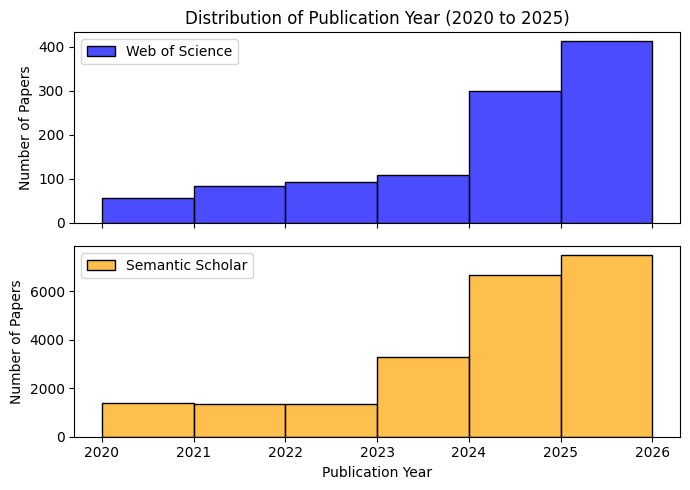

In [49]:
# Plot Distribution of Publication Years
fig, axes = plt.subplots(2, 1, figsize=(7, 5), sharex=True)

sns.histplot(df_WoS_final['year'], color='blue', ax=axes[0], 
             kde=False, stat='count', bins=range(2020, 2027), alpha=0.7)
axes[0].set_title('Distribution of Publication Year (2020 to 2025)')
axes[0].set_ylabel('Number of Papers')
axes[0].legend(['Web of Science'])

sns.histplot(df_SS_final['year'], color='orange', ax=axes[1], 
             kde=False, stat='count', bins=range(2020, 2027), alpha=0.7)
axes[1].set_title('')
axes[1].set_xlabel('Publication Year')
axes[1].set_ylabel('Number of Papers')
axes[1].legend(['Semantic Scholar'])

plt.tight_layout()
plt.show()

ValueError: Could not interpret value `index` for `x`. An entry with this name does not appear in `data`.

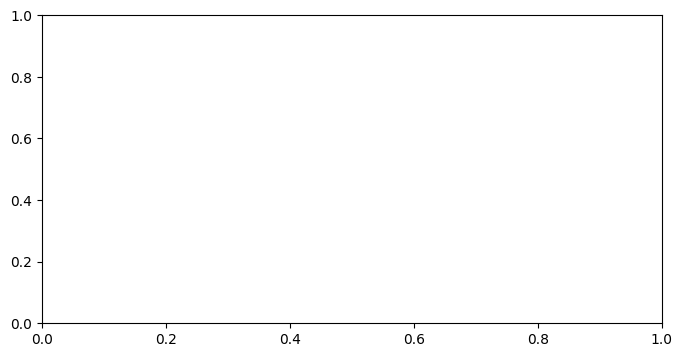

In [17]:
# plot the distribution of df_SS_final 'publicationTypes' column
fig, ax = plt.subplots(figsize=(8, 4))
pubtype_counts = df_SS_final['publicationTypes'].value_counts().reset_index() 
sns.barplot(data=pubtype_counts, x='index', y='publicationTypes', ax=ax, palette='viridis')
ax.set_title('Distribution of Publication Types in Semantic Scholar Results')
ax.set_xlabel('Publication Type')
ax.set_ylabel('Number of Papers')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


## Compare Search Results

In [65]:
df_WoS_final = df_WoS_final.copy()
df_SS_final = df_SS_final.copy()

df_WoS_final.loc[:, 'norm_title'] = df_WoS_final['title'].map(normalize_title)
df_SS_final.loc[:, 'norm_title'] = df_SS_final['title'].map(normalize_title)

# Check for missing papers in SS by DOI first, then by normalized title
wos_dois = set(df_WoS_final['doi'].dropna().str.lower())
ss_dois = set(df_SS_final['doi'].dropna().str.lower())

missing_by_doi = df_WoS_final[df_WoS_final['doi'].notna() & ~df_WoS_final['doi'].str.lower().isin(ss_dois)]
print(f'Number of papers missing in SS by DOI: {len(missing_by_doi)}')

ss_norm_titles = set(df_SS_final['norm_title'])
missing_by_title = df_WoS_final[df_WoS_final['doi'].isna() & ~df_WoS_final['norm_title'].isin(ss_norm_titles)]
print(f'Number of papers missing in SS by Title: {len(missing_by_title)}')

# Combine results
df_missing_in_SS = pd.concat([missing_by_doi, missing_by_title]).drop_duplicates().reset_index(drop=True)
df_missing_in_SS

Number of papers missing in SS by DOI: 982
Number of papers missing in SS by Title: 102


,title,year,authors,doi,sourceType,norm_title
0,Predictive value of PET-CT imaging versus AGO-...,2008,"Lenhard, S. M.; Burges, A.; Johnson, T. R. C.;...",10.1016/j.ejogrb.2008.05.006,Article,predictive value of pet ct imaging versus ago ...
1,Eysenck Personality Questionnaire: A Comparati...,2024,"Antal, Margit; Beder, Norbert",10.47745/ausi-2024-0012,Article,eysenck personality questionnaire a comparativ...
2,Performance and biases of Large Language Model...,2024,"Qu, Yao; Wang, Jue",10.1057/s41599-024-03609-x,Article,performance and biases of large language model...
3,Prediction of normalized biodiesel properties ...,2010,"Garcia, Manuel; Gonzalo, Alberto; Luis Sanchez...",10.1016/j.biortech.2010.01.111,Article,prediction of normalized biodiesel properties ...
4,"Use of stationary computers, notebooks, and PD...",2004,"Schneid, M",10.1024/0044-3514.35.1.3,Article,use of stationary computers notebooks and pdas...
...,...,...,...,...,...,...
1079,EXPERIMENTAL INVESTIGATION ON STRUCTURAL LIGHT...,2020,"Alsarayreh, Ali Ibrahim Mohammad; Bin Othman, ...",NaN,Article,experimental investigation on structural light...
1080,Pollen assemblages of surface sediments from t...,2018,"de los Angeles Pereira, Elizabeth; Torres, Gon...",NaN,Article,pollen assemblages of surface sediments from t...
1081,Ethnobotanical survey of a fallow plot for med...,2010,"Oni, Peter I.",NaN,Article,ethnobotanical survey of a fallow plot for med...
1082,LDPE/WHEAT GLUTEN HUSK BIOCOMPOSITES APPLIED T...,2015,"Rangel-Vazquez, Norma-Aurea; Bonilla Petriciol...",NaN,Editorial Material,ldpe wheat gluten husk biocomposites applied t...


In [60]:
df_WoS_final

,title,year,authors,doi,sourceType,norm_title
0,From Values to Opinions: Predicting Human Beha...,2023,"Kane, Dongjun; Parke, JoonSuk; Jo, Yohan; Bak,...",NaN,Proceedings Paper,from values to opinions predicting human behav...
1,Simulating Public Opinion: Comparing Distribut...,2025,"Miranda, Fernando; Balbi, Pedro Paulo",10.3390/e27090923,Article,simulating public opinion comparing distributi...
2,Predictive value of PET-CT imaging versus AGO-...,2008,"Lenhard, S. M.; Burges, A.; Johnson, T. R. C.;...",10.1016/j.ejogrb.2008.05.006,Article,predictive value of pet ct imaging versus ago ...
3,Using generative AI for interview simulations ...,2025,"Millen, Jonathan I.",10.1128/jmbe.00122-25,Article,using generative ai for interview simulations ...
4,Towards realistic evaluation of cultural value...,2025,"Liu, Haijiang; Cao, Yong; Wu, Xun; Qiu, Chen; ...",10.1016/j.ipm.2025.104099,Article,towards realistic evaluation of cultural value...
...,...,...,...,...,...,...
1675,"Secure in Diversity? Transborder Ethnicity, Tr...",2024,"Smith, David J.",10.1093/jogss/ogae033,Article,secure in diversity transborder ethnicity tran...
1676,Phase transitions for the long-time behavior o...,2007,"Greven, A.; Den Hollander, F.",10.1214/009117906000001060,Article,phase transitions for the long time behavior o...
1677,"""Hope the Russians Love Their Children Too"": R...",2025,"Smetana, Michal; Onderco, Michal",10.1093/jogss/ogaf012,Article,hope the russians love their children too russ...
1678,Detailed review of transgenic rodent mutation ...,2005,"Lambert, LB; Singer, TM; Boucher, SE; Douglas, GR",10.1016/j.mrrev.2005.04.002,Review,detailed review of transgenic rodent mutation ...


In [ ]:
# Merge df_WoS_final and df_SS_final
df_merged = pd.concat([df_WoS_final, df_SS_final], ignore_index=True)

df_merged = df_merged.drop_duplicates(subset=['doi'], keep='first')
df_merged = df_merged.drop_duplicates(subset=['title'], keep='first')

df_merged.reset_index(drop=True, inplace=True)

# filter for years 2022 to 2025
df_merged = df_merged[(df_merged['year'] >= 2022)]
df_merged

,title,year,authors,doi,sourceType,publicationTypes,citationCount
0,From Values to Opinions: Predicting Human Beha...,2023,"Kane, Dongjun; Parke, JoonSuk; Jo, Yohan; Bak,...",NaN,Proceedings Paper,NaN,NaN
1,Simulating Public Opinion: Comparing Distribut...,2025,"Miranda, Fernando; Balbi, Pedro Paulo",10.3390/e27090923,Article,NaN,NaN
3,Using generative AI for interview simulations ...,2025,"Millen, Jonathan I.",10.1128/jmbe.00122-25,Article,NaN,NaN
4,Towards realistic evaluation of cultural value...,2025,"Liu, Haijiang; Cao, Yong; Wu, Xun; Qiu, Chen; ...",10.1016/j.ipm.2025.104099,Article,NaN,NaN
5,Can large language models estimate public opin...,2024,"Lee, Sanguk; Peng, Tai-Quan; Goldberg, Matthew...",10.1371/journal.pclm.0000429,Article,NaN,NaN
...,...,...,...,...,...,...,...
20638,PSIV-20 An in Vitro Digestion Procedure Using ...,2023,"No A Park, Jeonghyeon Son, B. G. Kim",10.1093/jas/skad341.350,NaN,[JournalArticle],0.0
20639,FRAMEWORK DE GERAÇÃO DE VALOR PARA TRANSFORMAÇ...,2025,Victor Rodrigues Leite,10.69849/revistaft/ma10202509261059,NaN,[JournalArticle],0.0
20640,Students’ perceptions of an artificially intel...,2024,A. Alshwiah,10.1108/qrj-06-2024-0117,NaN,[JournalArticle],0.0
20641,A Comparative Analysis of Large Language Model...,2024,"Abdelrahman Lotfy, Ahmed Ashraf, Mariam Baraka...",10.1109/NILES63360.2024.10753166,NaN,"[JournalArticle, Conference]",0.0
